In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import mlflow
import mlflow.keras
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set the MLflow tracking URI if you have a remote server, or it defaults to the local file system
# mlflow.set_tracking_uri("file:///mlruns")

In [48]:
# Load your dataset
data = pd.read_csv('../data/iot_sensor_dataset.csv')

# Assume 'target' is the column you are predicting
X = data.drop('fail', axis=1)
y = data['fail']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
def create_model(input_shape):
    model = keras.models.Sequential([
        keras.layers.Dense(32, activation='relu', input_shape=input_shape),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Create a model instance
model = create_model((X_train_scaled.shape[1],))

Epoch 1/50
19/19 [==============================] - 1s 10ms/step - loss: 0.6390 - accuracy: 0.5977 - val_loss: 0.5574 - val_accuracy: 0.6291 - lr: 0.0010
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 0.5571 - accuracy: 0.6722 - val_loss: 0.4922 - val_accuracy: 0.7285 - lr: 0.0010
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.4984 - accuracy: 0.7417 - val_loss: 0.4403 - val_accuracy: 0.8477 - lr: 0.0010
Epoch 4/50
19/19 [==============================] - 0s 3ms/step - loss: 0.4430 - accuracy: 0.8129 - val_loss: 0.3965 - val_accuracy: 0.8742 - lr: 0.0010
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 0.4240 - accuracy: 0.8377 - val_loss: 0.3618 - val_accuracy: 0.9073 - lr: 0.0010
Epoch 6/50
19/19 [==============================] - 0s 3ms/step - loss: 0.3684 - accuracy: 0.8891 - val_loss: 0.3312 - val_accuracy: 0.9007 - lr: 0.0010
Epoch 7/50
19/19 [==============================] - 0s 3ms/step - loss: 0.3538 - 

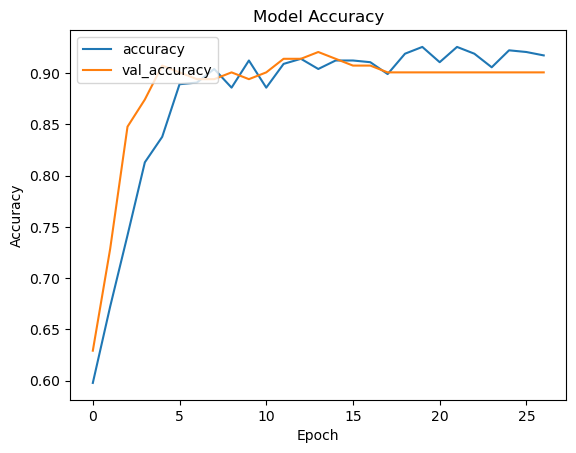

<Figure size 640x480 with 0 Axes>

In [50]:
# Start an MLflow run
with mlflow.start_run():
    # Log model parameters and training details
    mlflow.log_params({"optimizer": "adam", "num_layers": 3, "dropout_rate": 0.25})
    
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)

    # Train the model
    history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2,
                        callbacks=[early_stopping, reduce_lr])

    # Save weights directly to HDF5
    model.save('model_weights.h5')
    
    # Log metrics
    loss, accuracy = model.evaluate(X_test_scaled, y_test)
    mlflow.log_metrics({"loss": loss, "accuracy": accuracy})
    
    # Plot training history
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()
    
    # Save and log plots
    plt.savefig("../static/plots/accuracy_curve.png")
    mlflow.log_artifact("../static/plots/accuracy_curve.png")


In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Predicting the Test set results
y_pred = model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary output

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
tn, fp, fn, tp = cm.ravel()

# Calculate other metrics
accuracy = accuracy_score(y_test, y_pred_classes)

6/6 [==============================] - 0s 3ms/step


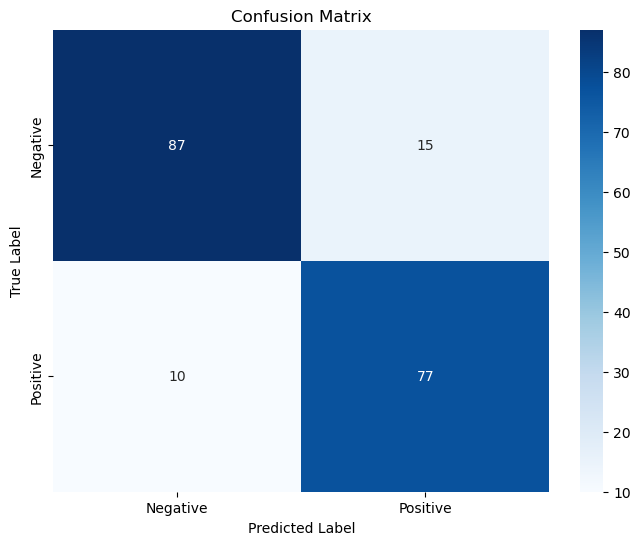

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [53]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       102
           1       0.84      0.89      0.86        87

    accuracy                           0.87       189
   macro avg       0.87      0.87      0.87       189
weighted avg       0.87      0.87      0.87       189



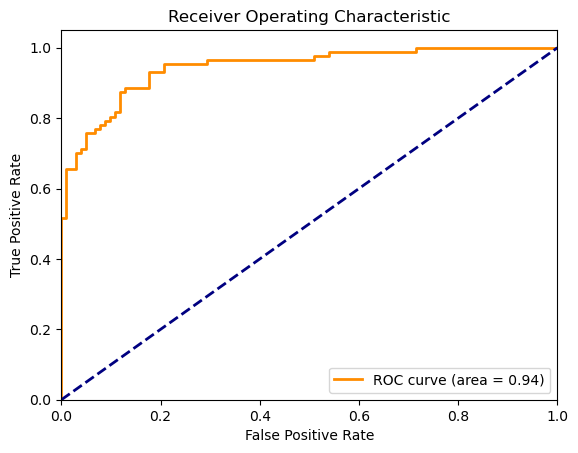

In [54]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [55]:
print(tf.__version__)

2.10.0
